# **SKIN LESION CLASSIFICATION**

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Load the image dataset
image_directory = "/kaggle/input/ham10000/Data/Data/train"

In [6]:
# Create training dataset with data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    # Add more augmentation layers as needed
])
dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

# Apply data augmentation to the training dataset
augmented_dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)


Found 5906 files belonging to 3 classes.
Using 4725 files for training.
Found 5906 files belonging to 3 classes.
Using 1181 files for validation.


# **DATA VISUALIZATION**

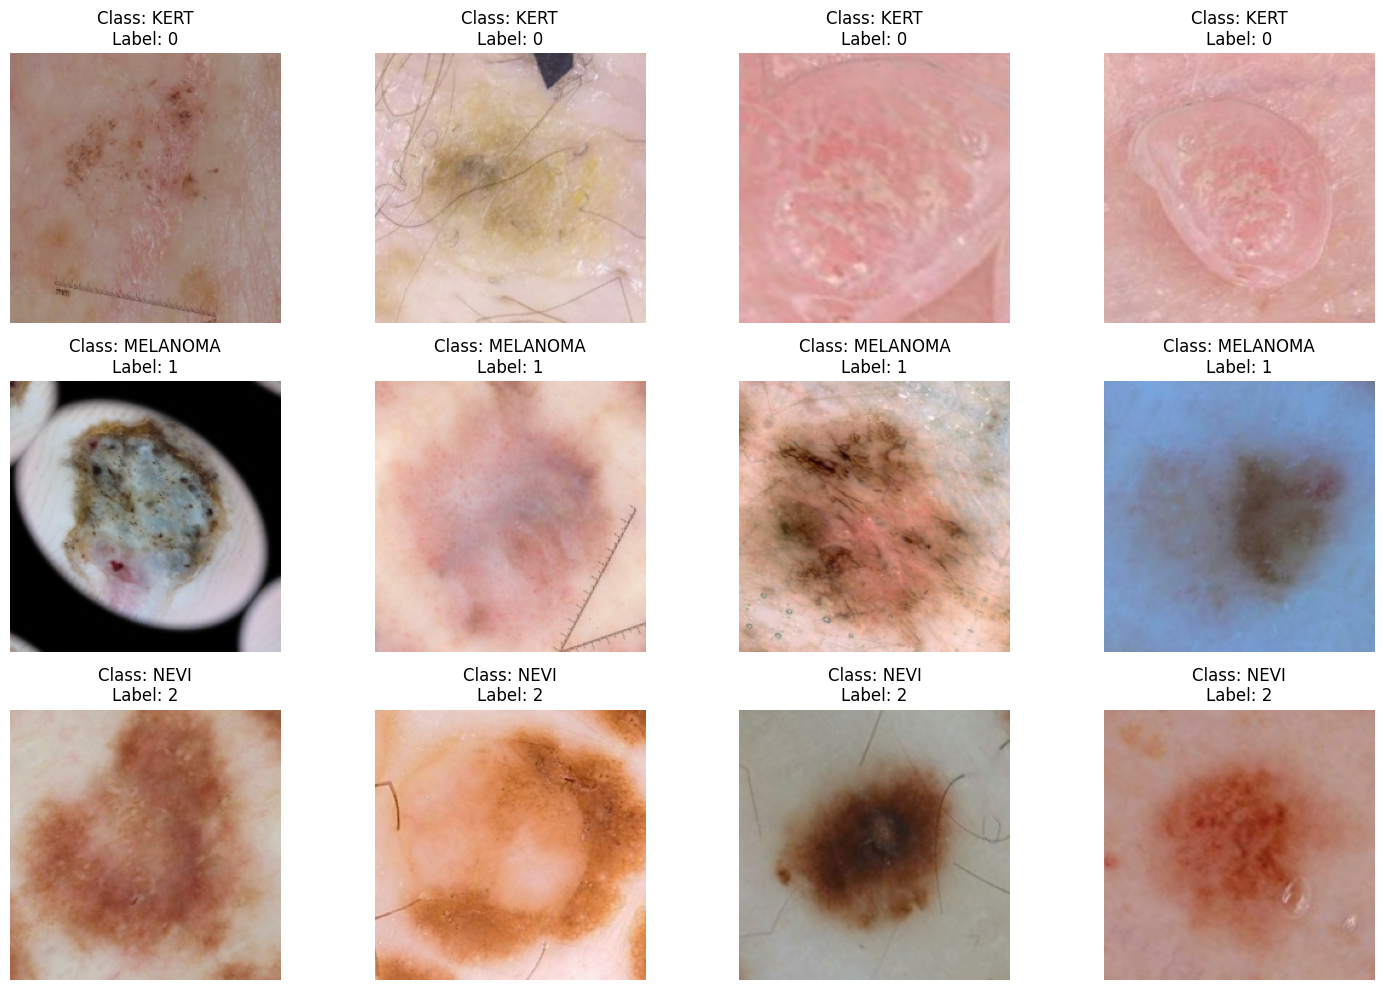

In [10]:
# Dictionary to map label indices to class names
class_names = {0: 'KERT', 1: 'MELANOMA', 2: 'NEVI'}

# Extract a few samples from each class for visualization
num_samples_per_class = 4

# Create a figure for plotting
plt.figure(figsize=(15, 10))

# Iterate over each class
for class_index in range(len(class_names)):
    samples_found = 0  # Track the number of samples found for this class
    iterator = iter(augmented_dataset)  # Use augmented dataset for visualization

    # Iterate through the entire dataset
    while samples_found < num_samples_per_class:
        try:
            image_batch, label_batch = next(iterator)
            # Filter the batch to get samples from the current class
            class_samples = [(image.numpy(), label.numpy()) for image, label in zip(image_batch, label_batch)
                             if np.argmax(label.numpy()) == class_index]

            # Check if there are enough samples for this class
            if len(class_samples) > 0:
                samples = class_samples[:num_samples_per_class - samples_found]

                # Plot the samples
                for i, (image, label) in enumerate(samples):
                    ax = plt.subplot(len(class_names), num_samples_per_class, class_index * num_samples_per_class + samples_found + i + 1)
                    plt.imshow(image.astype("uint8"))
                    plt.title(f"Class: {class_names[class_index]}\nLabel: {np.argmax(label)}")
                    plt.axis("off")

                samples_found += len(samples)
        except StopIteration:
            print(f"Not enough samples for class {class_names[class_index]}")
            break

# Show the plot
plt.tight_layout()
plt.show()

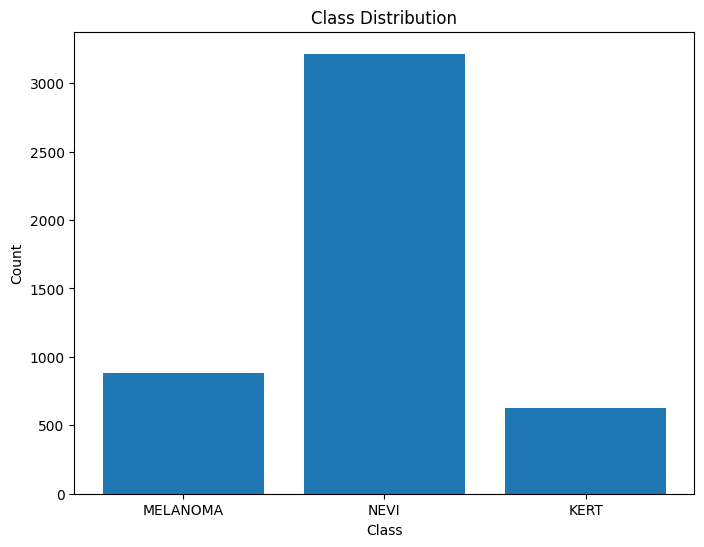

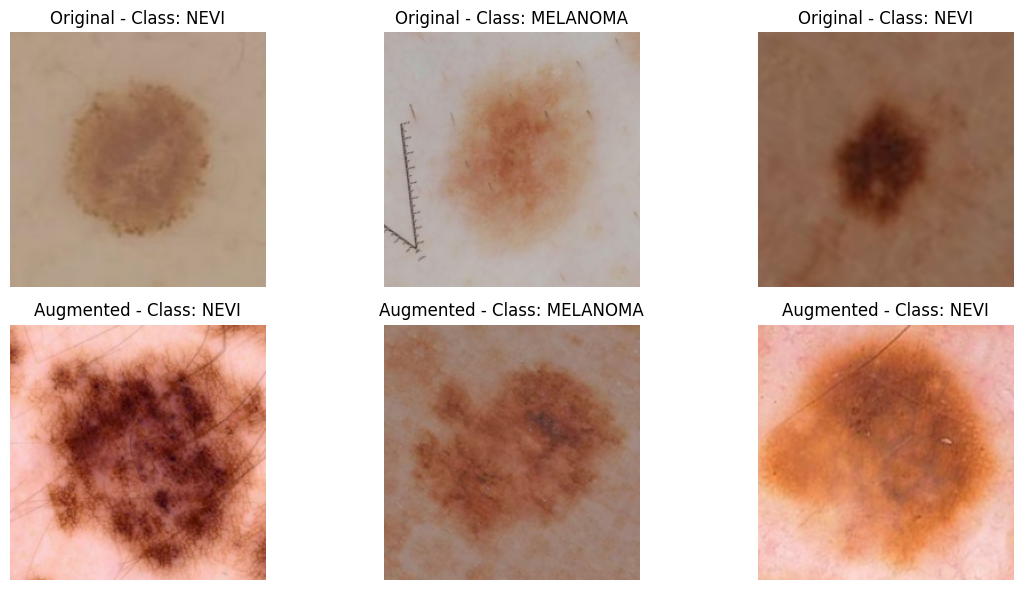

In [11]:
import matplotlib.pyplot as plt
import random

# Display random images from each class
def display_random_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 10))
    
    for class_idx in range(len(class_names)):
        class_samples = [sample for sample in dataset.take(num_images) if np.argmax(sample[1].numpy()) == class_idx]
        
        for i, (image, label) in enumerate(class_samples):
            plt.subplot(len(class_names), num_images, class_idx * num_images + i + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(f"Class: {class_names[class_idx]}\nLabel: {np.argmax(label)}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize class distribution
def plot_class_distribution(class_distribution):
    plt.figure(figsize=(8, 6))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Calculate class distribution
class_distribution = {}
for _, labels in dataset:
    for label in labels.numpy():
        class_name = class_names[np.argmax(label)]
        if class_name not in class_distribution:
            class_distribution[class_name] = 1
        else:
            class_distribution[class_name] += 1

# Visualize class distribution
plot_class_distribution(class_distribution)

# Visualize data augmentation
augmented_samples = [sample for sample in augmented_dataset.take(2)]

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_samples[0][0][i].numpy().astype("uint8"))
    plt.title(f"Original - Class: {class_names[np.argmax(augmented_samples[0][1][i].numpy())]}")
    plt.axis("off")

    plt.subplot(2, 3, i + 4)
    plt.imshow(augmented_samples[1][0][i].numpy().astype("uint8"))
    plt.title(f"Augmented - Class: {class_names[np.argmax(augmented_samples[1][1][i].numpy())]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# **CNN MODEL**

In [12]:
# Build the model
tf.random.set_seed(42)
tf.keras.backend.clear_session()

from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [13]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [10]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Train the model
history = model.fit(
    augmented_dataset,
    validation_data=validation_dataset,
    epochs=10
)



Epoch 1/10
148/148 [==============================] - 63s 306ms/step - loss: 79.1917 - accuracy: 0.6250 - val_loss: 0.7708 - val_accuracy: 0.7172
Epoch 2/10
148/148 [==============================] - 41s 274ms/step - loss: 0.8748 - accuracy: 0.6760 - val_loss: 0.8349 - val_accuracy: 0.7155
Epoch 3/10
148/148 [==============================] - 42s 279ms/step - loss: 1.8203 - accuracy: 0.6656 - val_loss: 0.8076 - val_accuracy: 0.7155
Epoch 4/10
148/148 [==============================] - 41s 277ms/step - loss: 3.6825 - accuracy: 0.6557 - val_loss: 0.7974 - val_accuracy: 0.7155
Epoch 5/10
148/148 [==============================] - 39s 262ms/step - loss: 0.8539 - accuracy: 0.6802 - val_loss: 0.7909 - val_accuracy: 0.7155
Epoch 6/10
148/148 [==============================] - 40s 271ms/step - loss: 0.8529 - accuracy: 0.6806 - val_loss: 0.7915 - val_accuracy: 0.7155
Epoch 7/10
148/148 [==============================] - 41s 273ms/step - loss: 0.8516 - accuracy: 0.6804 - val_loss: 0.7917 - val_a

# **MODEL EVALUATION**

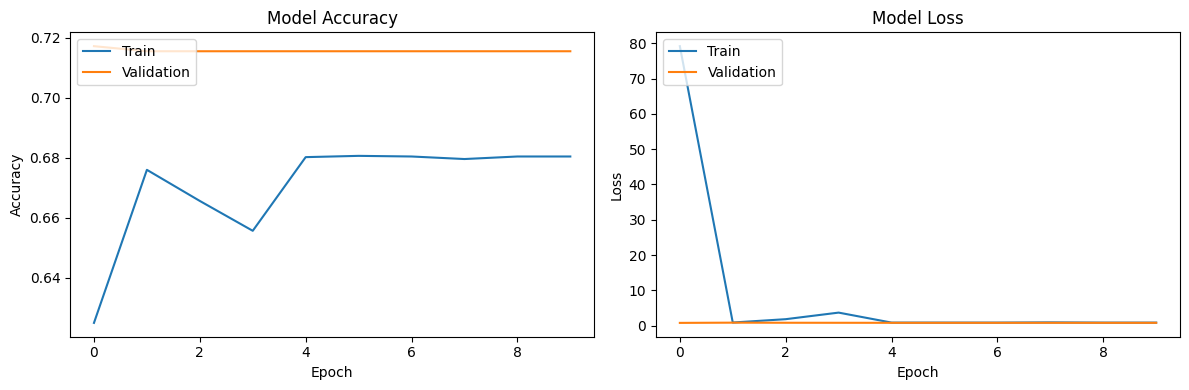

In [11]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


